# Produce Hourly Shaped Hydro Profile for the Western Interconnection

USACE: U.S. Army Corps of Engineers

The [USACE’s Northwestern hydro system](https://www.nwd-wc.usace.army.mil/dd/common/dataquery/www/) is used to obtain a generic hydro profile to be applied to the generators in the Western Interconnection, with the exception of Wyoming and California (see our [publication](https://arxiv.org/abs/2002.06155) for more details). Also, we obtain additional information on dams' coordinates and capacity on [Wikipedia](https://en.wikipedia.org/wiki/List_of_dams_in_the_Columbia_River_watershed). The power output on 4/26/2019 16:00 UTC for two dams (WAN and PRD) exceeds their respective capacity. These outliers were replaced with an average of the hour before and after the outlier hour, for each of the two dams

In [1]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from powersimdata.input.grid import Grid

from prereise.gather.helpers import trim_eia_form_923
from prereise.gather.helpers import get_monthly_net_generation
from prereise.gather.hydrodata.eia.net_demand import get_net_demand_profile
from prereise.gather.hydrodata.eia.helpers import scale_profile
from prereise.gather.hydrodata.eia.decompose_profile import(
    get_profile_by_state,
    get_normalized_profile,
)

Create an instance of the base grid

In [2]:
grid = Grid(["Western"])

Reading bus.csv
Reading plant.csv
Reading gencost.csv
Reading branch.csv
Reading dcline.csv
Reading sub.csv
Reading bus2sub.csv
Reading zone.csv


In [3]:
hydro_index = pd.date_range(start="2016-01-01 00:00:00", end="2016-12-31 23:00:00", freq="H")
hydro_columns = grid.plant[grid.plant.type == "hydro"].index.tolist()
hydro_v2 = pd.DataFrame(index = hydro_index, columns = hydro_columns)

Trim EIA form 923 to remove unnecessary columns

In [4]:
plant_generation = trim_eia_form_923('EIA923_Schedules_2_3_4_5_M_12_2016_Final_Revision.xlsx')

## 1. California Hydro Profile

### Calculate the net demand profile in California for the scenario

In [5]:
net_demand_ca = get_net_demand_profile('CA', interconnect="Western")

--> Loading wind
--> Loading solar
--> Loading demand


### Calculate the monthly total net generation from the 2016 EIA Form 923

In [6]:
hydro_monthly_generation_ca = get_monthly_net_generation('CA', plant_generation, 'hydro')

### Scale Hourly Net Demand Profile

In [7]:
total_hydro_profile_ca = scale_profile(net_demand_ca, hydro_monthly_generation_ca)

### Decompose Total Hydro Profile into Plant Level Profile

In [8]:
hydro_profile_ca = get_profile_by_state(total_hydro_profile_ca, 'CA')

In [9]:
for i in hydro_profile_ca.columns:
    hydro_v2[i] = hydro_profile_ca[i].copy()

## 2. Washington State Hydro profile

### Get Hourly Profile for Top 20 Dams in Washington from US Army Corps

In [10]:
filename = '../../data/usace_hydro_2019.csv'
hydro_profile_army_corps = pd.read_csv(filename, header=0, index_col=0, parse_dates=True, squeeze=True)

### Calculate the monthly total net generation from the 2016 EIA Form 923

In [11]:
hydro_monthly_generation_wa = get_monthly_net_generation('WA', plant_generation, 'hydro')

### Scale Top 20 Dams Hourly Profile Based on EIA Monthly Total Net Genration

In [12]:
total_hydro_profile_wa = scale_profile(hydro_profile_army_corps, hydro_monthly_generation_wa)

### Decompose Total Hydro profile Plant Level Profile

In [13]:
hydro_profile_wa = get_profile_by_state(total_hydro_profile_wa, 'WA')

In [14]:
for i in hydro_profile_wa.columns:
    hydro_v2[i] = hydro_profile_wa[i].copy()

## 3. Other States in the Western Interconnection

In [15]:
states = ['OR','AZ','NV','ID','MT','UT','CO','NM']
for s in states:
    hydro_monthly_generation = get_monthly_net_generation(s, plant_generation, 'hydro')
    total_hydro_profile = scale_profile(hydro_profile_army_corps, hydro_monthly_generation)
    hydro_profile = get_profile_by_state(total_hydro_profile, s)
    for i in hydro_profile.columns:
        hydro_v2[i] = hydro_profile[i].copy()

## 4. Wyoming Hydro Profile
Washington state top 20 dams hourly profile is not suitable since it violates the maximum capacity in the peak hours. In this version, we apply a flat hourly profile based on the monthly total net generation from EIA 923 for WY in each month.

In [16]:
constant_hourly_profile = pd.Series([1] * 8784, index=hydro_v2.index)
hydro_monthly_generation_wy = get_monthly_net_generation('WY', plant_generation, 'hydro')
total_hydro_profile_wy = scale_profile(constant_hourly_profile, hydro_monthly_generation_wy)
hydro_profile_wy = get_profile_by_state(total_hydro_profile_wy, 'WY')
for i in hydro_profile_wy.columns:
    hydro_v2[i] = hydro_profile_wy[i].copy()

## 5. Profile Normalization

Normalized the final western_hydro_v2 profile

In [17]:
hydro_v2_normalize = get_normalized_profile(grid.plant[grid.plant.type == "hydro"], hydro_v2)

Store the final hydro v2 profile as a reference. Later we will roll back this profile based on TAMU hydro capacities 
to get the final hydro profile input of the simulation.

In [18]:
hydro_v2_normalize.to_csv('western_hydro_v2_normalize.csv')

## 5. Sanity check

### The total net generation in each state and each month should match

In [19]:
hydro_v2.sum().sum()

174543031.14099985

In [20]:
hydro_monthly_generation = {}
for s in ['WA','OR','CA','NV','ID','CO','MT','NM','AZ','UT','WY']:
    hydro_monthly_generation_by_plant = plant_generation[(plant_generation['Plant State'] == s) & 
                                                         ((plant_generation['AER\nFuel Type Code'] == 'HYC') | 
                                                          (plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
    # Drop unnecessary columns
    hydro_monthly_generation_by_plant.drop(hydro_monthly_generation_by_plant.columns[[0,1,2,3,4]], 
                                           axis=1, inplace=True)
    # Get monthly total net generation by summing up across plants with all positive values. 
    # Note that negative ones are included in actual demand
    hydro_monthly_generation[s] = list(hydro_monthly_generation_by_plant.replace('.',0).apply(
        lambda x: x[x>0].sum()).values)
sum_chk = 0
for val in hydro_monthly_generation.values():
    sum_chk += sum(val)
sum_chk

174543031.14099997

### Compare Energy Generated by Each Plant Each Hour to its Capacity in the Network
It should be lower than 1

<AxesSubplot:ylabel='Electric Energy (MWh)'>

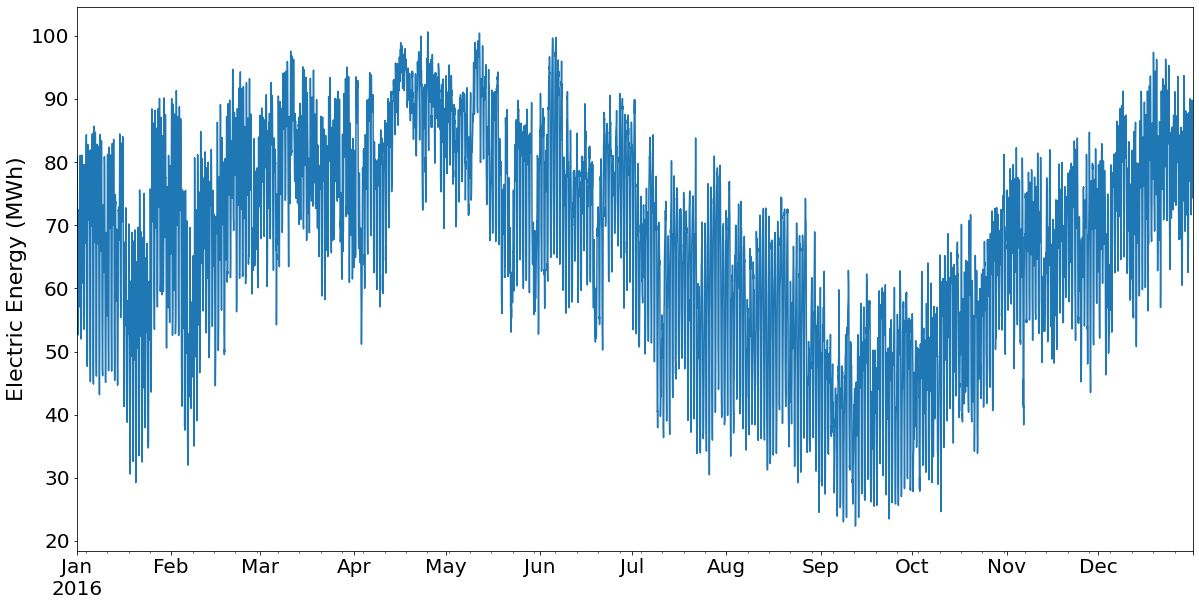

In [21]:
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()
ax.tick_params(which='both', labelsize=20)
ax.set_xlabel("")
ax.set_ylabel("Electric Energy (MWh)", fontsize=22)
hydro_v2[hydro_v2.columns[0]].plot(ax=ax)

In [22]:
hydro_v2_factor = hydro_v2.copy()
for i in hydro_v2.columns:
    hydro_v2_factor[i] /= grid.plant.loc[i]["Pmax"]

<AxesSubplot:ylabel='Capacity Factor'>

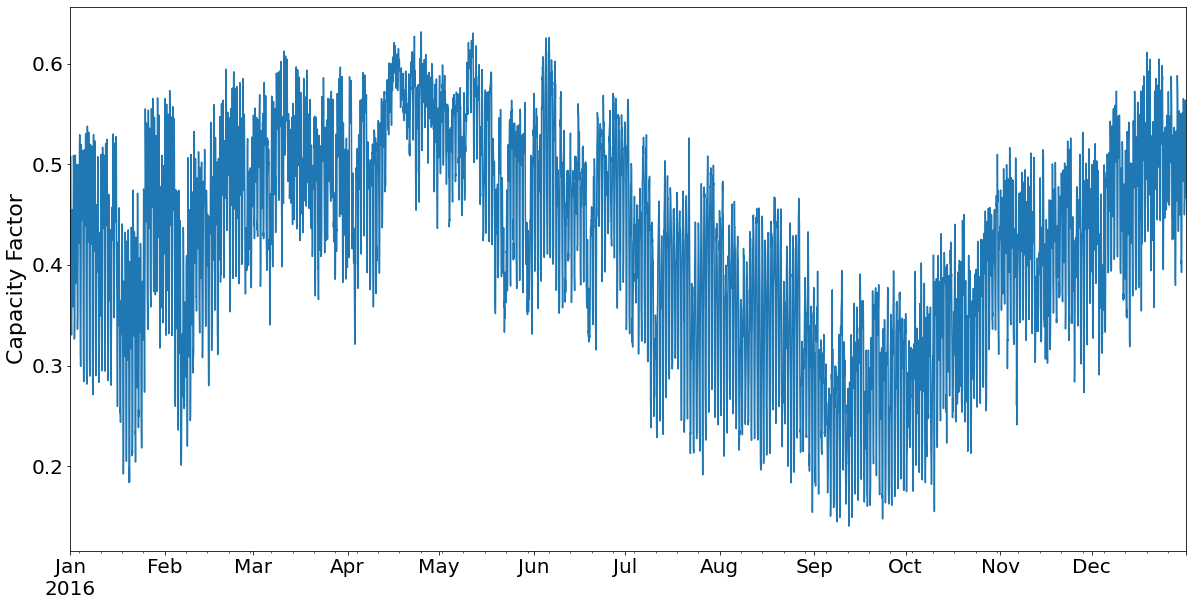

In [23]:
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()
ax.tick_params(which='both', labelsize=20)
ax.set_ylabel("Capacity Factor", fontsize=22)
hydro_v2_factor[hydro_v2_factor.columns[0]].plot(ax=ax)

As we apply a constant profile for hydro plants in WY and distribute uniformly across each hour based on the total generation from EIA, it turns out there are still some entries above the total capacity of the corresponding plants. This is solved during profile normalization, in which we clip the normalized profile beyond 1.

In [24]:
hydro_v2_factor.apply(lambda x: x>1).sum().sum()

10800